# predict_future_output 

## Goal: predict future outputs of the various electron gun beams


In [1]:
input_file = "dataset1_clean.csv"

In [2]:
# imports:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
# import helpers from sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# import utils and other models
import utils
import bla_avg_model
import bla_constant_model
import bla_linear_model
import bla_lasso_model
import bla_kernel_lr_model


In [3]:
# load in cleaned dataset
data = pd.read_csv(input_file, index_col=[0], skipinitialspace=True)

# add in integer index
data = data.reset_index().reset_index().set_index(["Time"])
#print(data.head())

In [4]:
# (year set to 1900 since that is the base for datetime objects)
# note date ranges are not inclusive
train_date_range = ["1900-01-01", "1900-01-08"]
test_date_range = ["1900-01-08", "1900-01-10"]

full_train, test = utils.split_by_day(data, train_date_range, test_date_range)

#print(full_train.info())
#print(test.info())

In [5]:
# split full_train into a train and valdiation set
validation_frac = .1
train, validation = train_test_split(full_train, test_size=validation_frac)
#print(validation.info())
#print(train.info())

In [6]:
# convert the train and validation dataframes into a set of np arrays that can be more readily used to train models
train_X_95th, train_X_median, train_X_5th = utils.split_X_into_quantiles(train, accept_index=True)
train_Y_95th, train_Y_median, train_Y_5th = utils.split_Y_into_beams_and_quantiles(train)

validation_X_95th, validation_X_median, validation_X_5th = utils.split_X_into_quantiles(validation, accept_index=True)
validation_Y_95th, validation_Y_median, validation_Y_5th = utils.split_Y_into_beams_and_quantiles(validation)

In [7]:
# Create versions of our training set wihtout an index column, and then conduct PCA to get dimension reduced versions
# of our dataset

# create training and validation X sets without the index column
train_X_95th_ni, train_X_median_ni, train_X_5th_ni = utils.split_X_into_quantiles(train, accept_index=False)
validation_X_95th_ni, validation_X_median_ni, validation_X_5th_ni = utils.split_X_into_quantiles(validation, accept_index=False)

# compute the PCA, using n=10 (learned from EDA.ipynb)
model_pca = PCA(n_components=10)
model_pca.fit(train_X_median_ni)

# apply PCA to the train and test median sets
train_X_median_ni = model_pca.transform(train_X_median_ni)
validation_X_median_ni = model_pca.transform(validation_X_median_ni)

### Evaluation Metrics

Mean Squared Error (MSE) computed using sklearn.metrics.mean_squared_error

In [8]:
def prop_within_bounds(actual, pred_95th, pred_5th):
    # return the proportion of points in actual that fall between the predicted 5th and 95th quantiles
    num_points = actual.shape[0]
    within_upper = actual > pred_95th
    within_lower = actual < pred_5th
    within_range = np.logical_and(within_upper, within_lower)
    return np.count_nonzero(within_range) / num_points

In [9]:
def plot_single_test_mse(mses, probs, title):
    beams = list(range(1, 7))
    mse_95 = [mse[0] for mse in mses]
    mse_median = [mse[1] for mse in mses]
    mse_5 = [mse[2] for mse in mses]
    
    # See: https://matplotlib.org/gallery/api/two_scales.html
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Beam (BLA#)')
    ax1.set_ylabel('Mean Squared Error', color="Red")
    ax1.plot(beams, mse_median, 'o', color="Red")
    ax1.tick_params(axis='y', labelcolor="Red")
    ax1.set_title(title)
    
    ax2 = ax1.twinx()
    
    ax2.set_ylabel('Proportion of Samples within 5-95 range', color="Blue")
    ax2.plot(beams, probs, 'o', color="Blue")
    ax2.tick_params(axis='y', labelcolor="Blue")
    ax2.set_ylim((0, 1))
    
    fig.tight_layout()
    plt.show()

## Baseline 1: BlaConstantModel

This model averages the input for each beam over the training period and predicts that value as constant for each beam.

This represents the most naive model, since it assumes independence from the features and labels, and no change in the 
labels over time.

### Train Baseline 1

In [10]:
baseline_1_95 = bla_constant_model.BlaConstantModel()
baseline_1_median = bla_constant_model.BlaConstantModel()
baseline_1_5 = bla_constant_model.BlaConstantModel()

baseline_1_95.train(train_X_median, train_Y_95th)
baseline_1_median.train(train_X_median, train_Y_median)
baseline_1_5.train(train_X_median, train_Y_5th)

baseline_1_pred_95 = [baseline_1_95.predict(validation_X_median, i) for i in range(6)]
baseline_1_pred_median = [baseline_1_median.predict(validation_X_median, i) for i in range(6)]
baseline_1_pred_5 = [baseline_1_5.predict(validation_X_median, i) for i in range(6)]


### Validate Baseline 1

In [11]:
baseline_1_valid_props = []
for i in range(6):
    p = prop_within_bounds(validation_Y_median[i], baseline_1_pred_95[i], baseline_1_pred_5[i])
    baseline_1_valid_props.append(p)
    
print(baseline_1_valid_props)

baseline_1_valid_mses = []
for i in range(6):
    mse_95 = mean_squared_error(validation_Y_95th[i], baseline_1_pred_95[i])
    mse_median = mean_squared_error(validation_Y_median[i], baseline_1_pred_median[i])
    mse_5 = mean_squared_error(validation_Y_5th[i], baseline_1_pred_5[i])
    baseline_1_valid_mses.append([mse_95, mse_median, mse_5])
    
print(baseline_1_valid_mses)

[0.2926587301587302, 0.5109126984126984, 0.18353174603174602, 0.47619047619047616, 0.1974206349206349, 0.36408730158730157]
[[0.04233151031701746, 0.041371137253930594, 0.04152075658401221], [0.03111054298550859, 0.030852490064723674, 0.0319087950225357], [0.26026564565440224, 0.2537000665424813, 0.24156949743663467], [0.02759764067943405, 0.027231135981895294, 0.026700193489564438], [0.11561396833631508, 0.11432091576228115, 0.11365403487652416], [0.06772293558259147, 0.06327506127341977, 0.061805500850889906]]


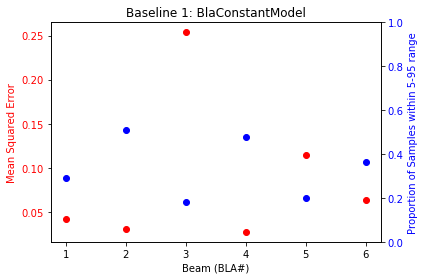

In [12]:
plot_single_test_mse(baseline_1_valid_mses, baseline_1_valid_props, "Baseline 1: BlaConstantModel")

## Baseline 2: BlaAvgModel
This model ignores differences in beams and tries to fit a single model for all beams by averaging the output from all
beams into a single "y" before fitting.

### Train Baseline 2

In [13]:
baseline_2_95 = bla_avg_model.BlaAvgModel()
baseline_2_median = bla_avg_model.BlaAvgModel()
baseline_2_5 = bla_avg_model.BlaAvgModel()

baseline_2_95.train(train_X_median, train_Y_95th)
baseline_2_median.train(train_X_median, train_Y_median)
baseline_2_5.train(train_X_median, train_Y_5th)

baseline_2_pred_95 = baseline_2_95.predict(validation_X_median)
baseline_2_pred_median = baseline_2_median.predict(validation_X_median)
baseline_2_pred_5 = baseline_2_5.predict(validation_X_median)

### Validate Baseline 2

In [14]:
baseline_2_valid_props = []
for i in range(6):
    p = prop_within_bounds(validation_Y_median[i], baseline_2_pred_95, baseline_2_pred_5)
    baseline_2_valid_props.append(p)
    
print(baseline_2_valid_props)

baseline_2_valid_mses = []
for i in range(6):
    mse_95 = mean_squared_error(validation_Y_95th[i], baseline_2_pred_95)
    mse_median = mean_squared_error(validation_Y_median[i], baseline_2_pred_median)
    mse_5 = mean_squared_error(validation_Y_5th[i], baseline_2_pred_5)
    baseline_2_valid_mses.append([mse_95, mse_median, mse_5])
    
print(baseline_2_valid_mses)

[0.0, 0.007936507936507936, 0.0, 0.0, 0.49404761904761907, 0.0]
[[17.859181125468915, 17.85239895229382, 17.83388560465205], [0.3674200530245752, 0.3269348116810805, 0.2867897606117711], [0.8638141341697495, 0.8363420563157092, 0.809769077628615], [13.124906406688268, 13.355105727325592, 13.576716167724877], [0.05567264489722217, 0.05940958120221881, 0.06403537435981449], [0.8815546144848284, 0.9023173236241873, 0.921691936027099]]


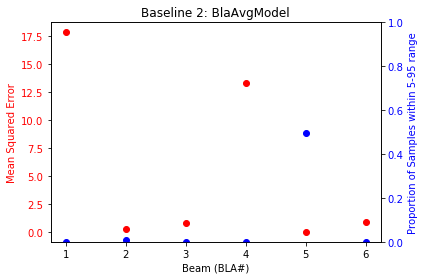

In [15]:
plot_single_test_mse(baseline_2_valid_mses, baseline_2_valid_props, "Baseline 2: BlaAvgModel")

## Model 1: Regular Least Squares Regression for Each Beam
This model trains a regular least squares model for each beam independently. Parameters for the least squares model are
standard, and an intercept is added.

### Train Model 1

In [16]:
model_1_95 = bla_linear_model.BlaLinearModel()
model_1_median = bla_linear_model.BlaLinearModel()
model_1_5 = bla_linear_model.BlaLinearModel()

model_1_95.train(train_X_median, train_Y_95th)
model_1_median.train(train_X_median, train_Y_median)
model_1_5.train(train_X_median, train_Y_5th)

model_1_pred_95 = [model_1_95.predict(validation_X_median, i) for i in range(6)]
model_1_pred_median = [model_1_median.predict(validation_X_median, i) for i in range(6)]
model_1_pred_5 = [model_1_5.predict(validation_X_median, i) for i in range(6)]

### Validate Model 1


In [17]:
model_1_valid_props = []
for i in range(6):
    p = prop_within_bounds(validation_Y_median[i], model_1_pred_95[i], model_1_pred_5[i])
    model_1_valid_props.append(p)
    print(model_1_median.models[i].score(validation_X_median, validation_Y_median[i]))
    
print(model_1_valid_props)

model_1_valid_mses = []
for i in range(6):
    mse_95 = mean_squared_error(validation_Y_95th[i], model_1_pred_95[i])
    mse_median = mean_squared_error(validation_Y_median[i], model_1_pred_median[i])
    mse_5 = mean_squared_error(validation_Y_5th[i], model_1_pred_5[i])
    model_1_valid_mses.append([mse_95, mse_median, mse_5])
    
print(model_1_valid_mses)

0.8287542632763336
0.8346685489013661
0.9519140546564938
0.8927148885472084
0.9761736854780744
0.6949445767889553
[0.7638888888888888, 0.9365079365079365, 0.7172619047619048, 0.7787698412698413, 0.8244047619047619, 0.5674603174603174]
[[0.007379911336275034, 0.007084550248936742, 0.007376609231160797], [0.005727172464997805, 0.0051008866773941935, 0.005933215671313272], [0.014420657812340526, 0.012194945982459758, 0.01774557998001071], [0.003083814136557193, 0.002920895124985558, 0.0031690730479343727], [0.002951448605084245, 0.0027216217400023437, 0.002861797856930228], [0.02135647313996904, 0.019300937177438277, 0.019277770215799243]]


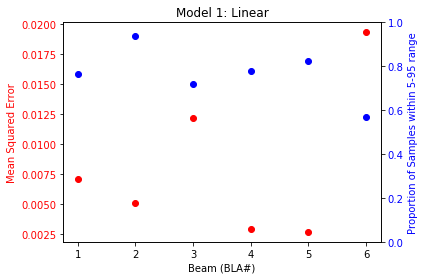

In [18]:
plot_single_test_mse(model_1_valid_mses, model_1_valid_props, "Model 1: Linear")

## Model 2: Lasso (Linear Regression with L1 Regularization)
This model adds a l1 regularization term to the objective function. This has the effect of penalizing nonzero coefficients,
which in turn minimizes the number of nonzero coefficients. 

### Train Model 2

In [19]:
model_2_95 = bla_lasso_model.BlaLassoModel(alpha=1)
model_2_median = bla_lasso_model.BlaLassoModel(alpha=1)
model_2_5 = bla_lasso_model.BlaLassoModel(alpha=1)

model_2_95.train(train_X_median, train_Y_95th)
model_2_median.train(train_X_median, train_Y_median)
model_2_5.train(train_X_median, train_Y_5th)

model_2_pred_95 = [model_2_95.predict(validation_X_median, i) for i in range(6)]
model_2_pred_median = [model_2_median.predict(validation_X_median, i) for i in range(6)]
model_2_pred_5 = [model_2_5.predict(validation_X_median, i) for i in range(6)]

### Validate Model 2

In [20]:
model_2_valid_props = []
for i in range(6):
    p = prop_within_bounds(validation_Y_median[i], model_2_pred_95[i], model_2_pred_5[i])
    model_2_valid_props.append(p)
    #print(model_2_median.models[i].coef_, model_2_median.models[i].intercept_)
    #print(model_2_median.models[i].score(validation_X_median, validation_Y_median[i]))
    
print(model_2_valid_props)

model_2_valid_mses = []
for i in range(6):
    mse_95 = mean_squared_error(validation_Y_95th[i], model_2_pred_95[i])
    mse_median = mean_squared_error(validation_Y_median[i], model_2_pred_median[i])
    mse_5 = mean_squared_error(validation_Y_5th[i], model_2_pred_5[i])
    model_2_valid_mses.append([mse_95, mse_median, mse_5])
    
print(model_2_valid_mses)

[0.29365079365079366, 0.8571428571428571, 0.29365079365079366, 0.5753968253968254, 0.6865079365079365, 0.41369047619047616]
[[0.038191142959507623, 0.037165752756117346, 0.037086255480715924], [0.010117068854847644, 0.009853522117230196, 0.010929819203271468], [0.23599928976489942, 0.22912305901348823, 0.21696658438352998], [0.021295179669969907, 0.020959973142466996, 0.020362233563743084], [0.006645501078537576, 0.006370319999878942, 0.006498936747862832], [0.06164509177982332, 0.0574395594312868, 0.05607967434516063]]


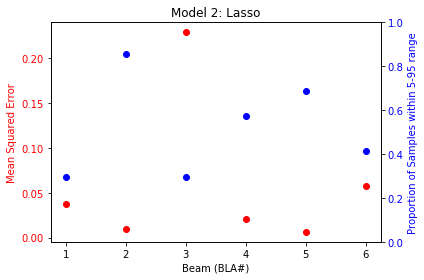

In [21]:
plot_single_test_mse(model_2_valid_mses, model_2_valid_props, "Model 2: Lasso")

## Model 3: Kernelized Linear Regression (l2 reg)

### Train Model 3

In [22]:
# Configure the kernel:
model_3_kernel = 'polynomial'
model_3_poly_degree = 3

In [23]:
model_3_95 = bla_kernel_lr_model.BlaKernelLRModel(kernel=model_3_kernel, degree=model_3_poly_degree, alpha=1)
model_3_median = bla_kernel_lr_model.BlaKernelLRModel(kernel=model_3_kernel, degree=model_3_poly_degree, alpha=1)
model_3_5 = bla_kernel_lr_model.BlaKernelLRModel(kernel=model_3_kernel, degree=model_3_poly_degree, alpha=1)

m1_start = time.time()
model_3_95.train(train_X_median_ni, train_Y_95th)
m2_start = time.time()
print("Finished Training Model 3 95th in %d seconds" % (m2_start - m1_start))

model_3_median.train(train_X_median_ni, train_Y_median)
m3_start = time.time()
print("Finished Training Model 3 median in %d seconds" % (m3_start - m2_start))

model_3_5.train(train_X_median_ni, train_Y_5th)
m3_finish = time.time()
print("Finished Training Model 3 5th in %d seconds" % (m3_finish - m3_start))

model_3_train_times = [m2_start - m1_start, m3_start - m2_start, m3_finish - m3_start]

Finished Training Model 3 95th in 59 seconds
Finished Training Model 3 median in 60 seconds
Finished Training Model 3 5th in 60 seconds


In [24]:
# split predictions into another cell because train time is so long
model_3_pred_95 = [model_3_95.predict(validation_X_median_ni, i) for i in range(6)]
model_3_pred_median = [model_3_median.predict(validation_X_median_ni, i) for i in range(6)]
model_3_pred_5 = [model_3_5.predict(validation_X_median_ni, i) for i in range(6)]

### Validate Model 3

In [25]:
model_3_valid_props = []
for i in range(6):
    p = prop_within_bounds(validation_Y_median[i], model_3_pred_95[i], model_3_pred_5[i])
    model_3_valid_props.append(p)
    #print(model_2_median.models[i].coef_, model_2_median.models[i].intercept_)
    #print(model_2_median.models[i].score(validation_X_median, validation_Y_median[i]))
    
print(model_3_valid_props)

model_3_valid_mses = []
for i in range(6):
    mse_95 = mean_squared_error(validation_Y_95th[i], model_3_pred_95[i])
    mse_median = mean_squared_error(validation_Y_median[i], model_3_pred_median[i])
    mse_5 = mean_squared_error(validation_Y_5th[i], model_3_pred_5[i])
    model_3_valid_mses.append([mse_95, mse_median, mse_5])
    
print(model_3_valid_mses)

[0.8234126984126984, 0.9305555555555556, 0.7966269841269841, 0.7748015873015873, 0.7569444444444444, 0.7212301587301587]
[[0.005632776519745328, 0.005244742739155629, 0.005867947483895395], [0.005676079878222895, 0.005181654723018559, 0.0062149033665113785], [0.009767129965501857, 0.008296771273876642, 0.013746028755723637], [0.0034749871569481564, 0.0032426001471357784, 0.003512969407409989], [0.004210503800457881, 0.003917708370892902, 0.004080354467089967], [0.0123789510605412, 0.010828128513284277, 0.01099302167087637]]


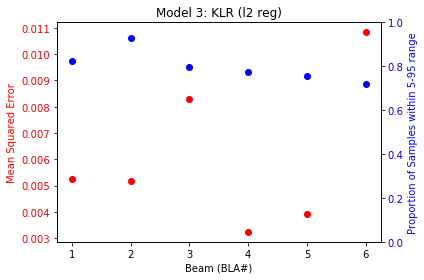

In [26]:
plot_single_test_mse(model_3_valid_mses, model_3_valid_props, "Model 3: KLR (l2 reg)")

## Model 4: Kernelized Linear Regression (with L2 reg)

### Train Model 4

In [27]:
# Configure the kernel:
model_4_kernel = 'polynomial'
model_4_poly_degree = 5

In [28]:
model_4_95 = bla_kernel_lr_model.BlaKernelLRModel(kernel=model_4_kernel, degree=model_4_poly_degree, alpha=1)
model_4_median = bla_kernel_lr_model.BlaKernelLRModel(kernel=model_4_kernel, degree=model_4_poly_degree, alpha=1)
model_4_5 = bla_kernel_lr_model.BlaKernelLRModel(kernel=model_4_kernel, degree=model_4_poly_degree, alpha=1)

m1_start = time.time()
model_4_95.train(train_X_median_ni, train_Y_95th)
m2_start = time.time()
print("Finished Training Model 4 95th in %d seconds" % (m2_start - m1_start))

model_4_median.train(train_X_median_ni, train_Y_median)
m3_start = time.time()
print("Finished Training Model 4 median in %d seconds" % (m3_start - m2_start))

model_4_5.train(train_X_median_ni, train_Y_5th)
m3_finish = time.time()
print("Finished Training Model 4 5th in %d seconds" % (m3_finish - m3_start))

model_3_train_times = [m2_start - m1_start, m3_start - m2_start, m3_finish - m3_start]

Finished Training Model 4 95th in 62 seconds
Finished Training Model 4 median in 61 seconds
Finished Training Model 4 5th in 62 seconds


In [29]:
# split predictions into another cell because train time is so long
model_4_pred_95 = [model_4_95.predict(validation_X_median_ni, i) for i in range(6)]
model_4_pred_median = [model_4_median.predict(validation_X_median_ni, i) for i in range(6)]
model_4_pred_5 = [model_4_5.predict(validation_X_median_ni, i) for i in range(6)]

### Validate Model 4

In [30]:
model_4_valid_props = []
for i in range(6):
    p = prop_within_bounds(validation_Y_median[i], model_4_pred_95[i], model_4_pred_5[i])
    model_4_valid_props.append(p)
    #print(model_2_median.models[i].coef_, model_2_median.models[i].intercept_)
    #print(model_2_median.models[i].score(validation_X_median, validation_Y_median[i]))
    
print(model_4_valid_props)

model_4_valid_mses = []
for i in range(6):
    mse_95 = mean_squared_error(validation_Y_95th[i], model_4_pred_95[i])
    mse_median = mean_squared_error(validation_Y_median[i], model_4_pred_median[i])
    mse_5 = mean_squared_error(validation_Y_5th[i], model_4_pred_5[i])
    model_4_valid_mses.append([mse_95, mse_median, mse_5])
    
print(model_4_valid_mses)

[0.873015873015873, 0.9424603174603174, 0.8680555555555556, 0.7658730158730159, 0.7876984126984127, 0.8075396825396826]
[[0.004599765689982401, 0.004139625328566361, 0.004733624942927858], [0.005195078844063355, 0.004552833275435446, 0.005464763904058417], [0.006767883183410958, 0.00558988122218553, 0.011460944057126882], [0.0038287841387660703, 0.0037660969336379595, 0.003947329705294578], [0.0037378884712389133, 0.003449805040347027, 0.003653753736322167], [0.007802135389461862, 0.006605714586820493, 0.006948493636154326]]


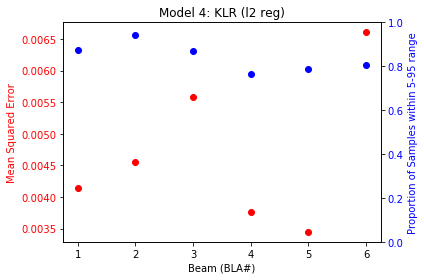

In [31]:
plot_single_test_mse(model_4_valid_mses, model_4_valid_props, "Model 4: KLR (l2 reg)")

## Evaluate Models on Test Set

### Configure Test Set

In [33]:
# split test set into a set of np arrays that can be more readily used to generate model predictions
test_X_95th, test_X_median, test_X_5th = utils.split_X_into_quantiles(test, accept_index=True)
test_Y_95th, test_Y_median, test_Y_5th = utils.split_Y_into_beams_and_quantiles(test)


In [34]:
test_X_95th_ni, test_X_median_ni, test_X_5th_ni = utils.split_X_into_quantiles(test, accept_index=False)

# apply PCA to the test X set
test_X_median_ni = model_pca.transform(test_X_median_ni)

### Generate Test Predictions for Each Model

#### Baseline 1

In [36]:
baseline_1_test_95 = [baseline_1_95.predict(test_X_median, i) for i in range(6)]
baseline_1_test_median = [baseline_1_median.predict(test_X_median, i) for i in range(6)]
baseline_1_test_5 = [baseline_1_5.predict(test_X_median, i) for i in range(6)]

baseline_1_test_props = []
for i in range(6):
    p = prop_within_bounds(test_Y_median[i], baseline_1_test_95[i], baseline_1_test_5[i])
    baseline_1_test_props.append(p)
    
print(baseline_1_test_props)

baseline_1_test_mses = []
for i in range(6):
    mse_95 = mean_squared_error(test_Y_95th[i], baseline_1_test_95[i])
    mse_median = mean_squared_error(test_Y_median[i], baseline_1_test_median[i])
    mse_5 = mean_squared_error(test_Y_5th[i], baseline_1_test_5[i])
    baseline_1_test_mses.append([mse_95, mse_median, mse_5])
    
print(baseline_1_test_mses)

[0.030975008799718408, 0.6092925026399155, 0.0, 0.11967617036254839, 0.0, 0.5550862372404083]
[[0.12458853121094761, 0.12607267279342668, 0.12440372941416007], [0.01938367850569693, 0.019961902259927753, 0.02092501999672663], [0.3013303432020003, 0.30159197232092966, 0.29928959186871407], [0.05242315256813088, 0.05200782562584092, 0.05163186334333449], [0.5255820138918248, 0.5215197461367481, 0.5192682411039908], [0.0253023882971028, 0.022835419021744182, 0.022126881921578207]]


#### Baseline 2

In [37]:
baseline_2_test_95 = baseline_2_95.predict(test_X_median)
baseline_2_test_median = baseline_2_median.predict(test_X_median)
baseline_2_test_5 = baseline_2_5.predict(test_X_median)

baseline_2_test_props = []
for i in range(6):
    p = prop_within_bounds(test_Y_median[i], baseline_2_test_95, baseline_2_test_5)
    baseline_2_test_props.append(p)
    
print(baseline_2_test_props)

baseline_2_test_mses = []
for i in range(6):
    mse_95 = mean_squared_error(test_Y_95th[i], baseline_2_test_95)
    mse_median = mean_squared_error(test_Y_median[i], baseline_2_test_median)
    mse_5 = mean_squared_error(test_Y_5th[i], baseline_2_test_5)
    baseline_2_test_mses.append([mse_95, mse_median, mse_5])
    
print(baseline_2_test_mses)

[0.0, 0.0, 0.0, 0.0, 0.08799718409010912, 0.00035198873636043646]
[[17.241123212277646, 17.31432043486161, 17.30564089667577], [0.9675614727974988, 0.8908876647259625, 0.8252514578869413], [0.5327588311719159, 0.49625098854615873, 0.4829711971487932], [14.606232690019741, 14.797946453020964, 15.031950361361401], [0.061668253090258605, 0.051755487865303026, 0.04205816089704735], [0.35350563092910486, 0.3670766317642728, 0.3744750834897339]]


#### Model 1

In [38]:
model_1_test_95 = [model_1_95.predict(test_X_median, i) for i in range(6)]
model_1_test_median = [model_1_median.predict(test_X_median, i) for i in range(6)]
model_1_test_5 = [model_1_5.predict(test_X_median, i) for i in range(6)]

model_1_test_props = []
for i in range(6):
    p = prop_within_bounds(test_Y_median[i], model_1_test_95[i], model_1_test_5[i])
    model_1_test_props.append(p)
    
print(model_1_test_props)

model_1_test_mses = []
for i in range(6):
    mse_95 = mean_squared_error(test_Y_95th[i], model_1_test_95[i])
    mse_median = mean_squared_error(test_Y_median[i], model_1_test_median[i])
    mse_5 = mean_squared_error(test_Y_5th[i], model_1_test_5[i])
    model_1_test_mses.append([mse_95, mse_median, mse_5])
    
print(model_1_test_mses)

[0.17388243576205561, 0.4818725800774375, 0.17529039070749736, 0.25519183386131644, 0.5110876451953538, 0.08870116156282999]
[[0.05035316045119126, 0.049059890687466794, 0.04869750778446188], [0.03493284912765718, 0.030558380105002305, 0.03315559377617532], [0.055154887268878426, 0.04761313268528729, 0.04461644691345828], [0.016411265096466912, 0.017157284013043388, 0.016487754789535694], [0.0074428062595411565, 0.006786579541710713, 0.007041083569972604], [0.08507493577164506, 0.0835583123262319, 0.08415493817602551]]


#### Model 2

In [43]:
model_2_test_95 = [model_2_95.predict(test_X_median, i) for i in range(6)]
model_2_test_median = [model_2_median.predict(test_X_median, i) for i in range(6)]
model_2_test_5 = [model_2_5.predict(test_X_median, i) for i in range(6)]

model_2_test_props = []
for i in range(6):
    p = prop_within_bounds(test_Y_median[i], model_2_test_95[i], model_2_test_5[i])
    model_2_test_props.append(p)
    # note to reader - the last item in each cofficient vector is the time index
    #print(model_2_median.models[i].coef_, model_2_median.models[i].intercept_)
    #print(model_2_median.models[i].score(validation_X_median, validation_Y_median[i]))
    
print(model_2_test_props)

model_2_test_mses = []
for i in range(6):
    mse_95 = mean_squared_error(test_Y_95th[i], model_2_test_95[i])
    mse_median = mean_squared_error(test_Y_median[i], model_2_test_median[i])
    mse_5 = mean_squared_error(test_Y_5th[i], model_2_test_5[i])
    model_2_test_mses.append([mse_95, mse_median, mse_5])
    
print(model_2_test_mses)

[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  1.95345719e-05] [-30.11196475]
[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000

#### Model 3

In [40]:
# split predictions into another cell because train time is so long
model_3_test_95 = [model_3_95.predict(test_X_median_ni, i) for i in range(6)]
model_3_test_median = [model_3_median.predict(test_X_median_ni, i) for i in range(6)]
model_3_test_5 = [model_3_5.predict(test_X_median_ni, i) for i in range(6)]

model_3_test_props = []
for i in range(6):
    p = prop_within_bounds(test_Y_median[i], model_3_test_95[i], model_3_test_5[i])
    model_3_test_props.append(p)
    #print(model_2_median.models[i].coef_, model_2_median.models[i].intercept_)
    #print(model_2_median.models[i].score(validation_X_median, validation_Y_median[i]))
    
print(model_3_test_props)

model_3_test_mses = []
for i in range(6):
    mse_95 = mean_squared_error(test_Y_95th[i], model_3_test_95[i])
    mse_median = mean_squared_error(test_Y_median[i], model_3_test_median[i])
    mse_5 = mean_squared_error(test_Y_5th[i], model_3_test_5[i])
    model_3_test_mses.append([mse_95, mse_median, mse_5])
    
print(model_3_test_mses)

[0.1689545934530095, 0.44948961633227735, 0.28898275255191835, 0.3280535022879268, 0.04188665962689194, 0.2675114396339317]
[[0.07855497663807175, 0.07814890461112203, 0.07824915873949936], [0.045801997715989, 0.04693438979309576, 0.04995902961221398], [0.07687543456552488, 0.07451621551987249, 0.07336711313227037], [0.01341964920001125, 0.013721335899028127, 0.013780241461286192], [0.15393396969529277, 0.15202469435309263, 0.1446522021096551], [0.17715364086859603, 0.18260771017716157, 0.18484329910676187]]


#### Model 4

In [42]:
model_4_test_95 = [model_4_95.predict(test_X_median_ni, i) for i in range(6)]
model_4_test_median = [model_4_median.predict(test_X_median_ni, i) for i in range(6)]
model_4_test_5 = [model_4_5.predict(test_X_median_ni, i) for i in range(6)]

model_4_test_props = []
for i in range(6):
    p = prop_within_bounds(test_Y_median[i], model_4_test_95[i], model_4_test_5[i])
    model_4_test_props.append(p)
    #print(model_2_median.models[i].coef_, model_2_median.models[i].intercept_)
    #print(model_2_median.models[i].score(validation_X_median, validation_Y_median[i]))
    
print(model_4_test_props)

model_4_test_mses = []
for i in range(6):
    mse_95 = mean_squared_error(test_Y_95th[i], model_4_test_95[i])
    mse_median = mean_squared_error(test_Y_median[i], model_4_test_median[i])
    mse_5 = mean_squared_error(test_Y_5th[i], model_4_test_5[i])
    model_4_test_mses.append([mse_95, mse_median, mse_5])
    
print(model_4_test_mses)



[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  1.95345719e-05] [-30.11196475]
[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000